# Normalize track data from Spotify

In Phase 1, we retrieved track data from Spotify and loaded it into a single table:
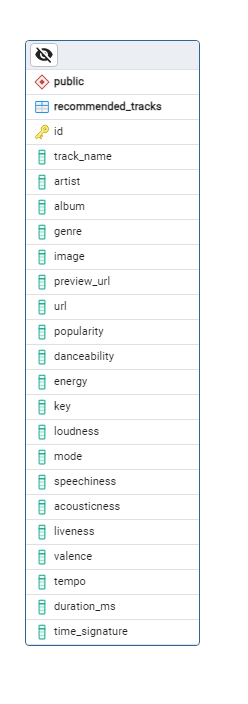

In this Phase 2, we normalize the data to create 4 tables in total: tracks, albums, artists and music_collection. The last table is an association table which links to each of the tables.

# Import libraries

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import psycopg2
import sqlalchemy as db

# Retrieve data from Spotify, 3 songs for each genre

In [2]:
# Set your Spotify API credentials
client_id = '6c2ff081fe494968a2e3a618c678fd62'
client_secret = '99da4179a82f4f999058535d8d9b47dc'

In [3]:
# Initialize the Spotipy client
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

In [4]:
# Define seed genres
seed_genres = ['anime', 'ambient', 'classical', 'country', 'chill', 'edm', 'folk', 'gospel', 'hip-hop', 'jazz', 'k-pop', 'latin', 'metal', 'pop', 'r-n-b', 'rock']

In [5]:
# Initialize an empty list to store track data
all_track_data = []

In [6]:
for seed_genre in seed_genres:
    recommended_tracks = sp.recommendations(seed_genres=[seed_genre], limit=3, country="SG")
    for track in recommended_tracks["tracks"]:
        track_data = {
            "track_name": track["name"],
            "artist": ", ".join(artist["name"] for artist in track["artists"]),
            "album": track["album"]["name"],
            "genre": seed_genre,
            "image": track["album"]["images"][0]["url"],
            "preview_url": track["preview_url"],
            "url": track['album']['external_urls']['spotify']
        }
        all_track_data.append(track_data)
        
        # Search for individual track by ID to get "popularity".
        track_search = sp.track(track['id'])
        track_data["popularity"] = track_search["popularity"]

        # Search for audio features of track by ID
        audio_features = sp.audio_features(track['id'])[0]
        for key, value in audio_features.items():
            track_data[key] = value

# Convert Spotify data to dataframe and inspect data

In [7]:
# Create a DataFrame from the track data
df = pd.DataFrame(all_track_data)

In [8]:
# Ensure print dataframe with full column width for url display, inspect
pd.set_option('display.max_colwidth', None)  

print(df.head())

                     track_name              artist  \
0  Nornir (RADIO ONSEN EUTOPIA)  YAKUSHIMARU Etsuko   
1       Best Friend - Live ver.            Prizmmy☆   
2                      Realize!               i☆Ris   
3             Gold Star Mothers             Hammock   
4                      Low Roar            Low Roar   

                                  album    genre  \
0                   RADIO ONSEN EUTOPIA    anime   
1                             TAKE OFF!    anime   
2                              Realize!    anime   
3  Maybe They Will Sing for Us Tomorrow  ambient   
4                              Low Roar  ambient   

                                                              image  \
0  https://i.scdn.co/image/ab67616d0000b273d5ca7cfbd330bde6b0a77724   
1  https://i.scdn.co/image/ab67616d0000b273059ad59cc0a6c609121a0aba   
2  https://i.scdn.co/image/ab67616d0000b2732984b57f72422e8fb2d1d119   
3  https://i.scdn.co/image/ab67616d0000b2732f2431822c1d3d2f5bf57a6b   
4

In [9]:
# Inspect info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        48 non-null     object 
 1   artist            48 non-null     object 
 2   album             48 non-null     object 
 3   genre             48 non-null     object 
 4   image             48 non-null     object 
 5   preview_url       36 non-null     object 
 6   url               48 non-null     object 
 7   popularity        48 non-null     int64  
 8   danceability      48 non-null     float64
 9   energy            48 non-null     float64
 10  key               48 non-null     int64  
 11  loudness          48 non-null     float64
 12  mode              48 non-null     int64  
 13  speechiness       48 non-null     float64
 14  acousticness      48 non-null     float64
 15  instrumentalness  48 non-null     float64
 16  liveness          48 non-null     float64
 17 

In [10]:
# Check for duplicates
print(df[df.duplicated()])

Empty DataFrame
Columns: [track_name, artist, album, genre, image, preview_url, url, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, id, uri, track_href, analysis_url, duration_ms, time_signature]
Index: []

[0 rows x 26 columns]


In [11]:
# Check if we retrieved all the genres
print(df['genre'].unique())

['anime' 'ambient' 'classical' 'country' 'chill' 'edm' 'folk' 'gospel'
 'hip-hop' 'jazz' 'k-pop' 'latin' 'metal' 'pop' 'r-n-b' 'rock']


In [12]:
# Make a copy to keep original as df
tracks_df = df.copy(deep=True)

In [13]:
# Check artist column and observe multiple values in one column
print(tracks_df['artist'].unique())

['YAKUSHIMARU Etsuko' 'Prizmmy☆' 'i☆Ris' 'Hammock' 'Low Roar'
 'The Cinematic Orchestra' 'Nils Frahm'
 'Gustav Holst, SWR Vokalensemble Stuttgart, Staatsopernchor Stuttgart, Stuttgart Radio Symphony Orchestra, Sir Roger Norrington'
 'Dario Marianelli' 'Trent Tomlinson' 'Kenny Chesney, Uncle Kracker'
 'Dierks Bentley' 'Tom Odell, Zwette' 'The Cranberries' 'Tycho' 'Ianick'
 'Benga' 'Laidback Luke, Hardwell' 'The Tallest Man On Earth'
 'The Barr Brothers' 'Bon Iver' 'Shirley Caesar'
 'Fred Hammond, Radical For Christ'
 'Hezekiah Walker, The Love Fellowship Crusade Choir' 'Migos, Drake'
 'Public Enemy' 'Logic' 'José James' 'Craig Taborn' 'Steps Ahead' 'STi'
 'GD&TOP' 'Yiruma' 'La Mosca Tse-Tse'
 'Chyno Miranda, Wisin, Gente De Zona' 'Prince Royce' 'In Flames' 'Dio'
 'Dimmu Borgir' 'Marshmello, Bastille' 'Jess Glynne' 'SAYGRACE, G-Eazy'
 'The Carters' 'Quincy' 'Erykah Badu' 'Van Halen' 'DED' 'Depeche Mode']


# Create 'artists' table

In [14]:
# Split values in 'artist' and create a new DataFrame for artists
artists_df = tracks_df['artist'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
print(artists_df)

0     YAKUSHIMARU Etsuko
1               Prizmmy☆
2                  i☆Ris
3                Hammock
4               Low Roar
             ...        
43                Quincy
44           Erykah Badu
45             Van Halen
46                   DED
47          Depeche Mode
Length: 62, dtype: object


In [15]:
# Rename 'artist' column and reset index
artists_df = artists_df.rename('artist').reset_index()
print(artists_df)

    index              artist
0       0  YAKUSHIMARU Etsuko
1       1            Prizmmy☆
2       2               i☆Ris
3       3             Hammock
4       4            Low Roar
..    ...                 ...
57     43              Quincy
58     44         Erykah Badu
59     45           Van Halen
60     46                 DED
61     47        Depeche Mode

[62 rows x 2 columns]


In [16]:
# Drop 'index' column
artists_df = artists_df.drop('index', axis=1)
print(artists_df)

                artist
0   YAKUSHIMARU Etsuko
1             Prizmmy☆
2                i☆Ris
3              Hammock
4             Low Roar
..                 ...
57              Quincy
58         Erykah Badu
59           Van Halen
60                 DED
61        Depeche Mode

[62 rows x 1 columns]


In [17]:
# Create a unique id for each artist
artists_df.insert(0, 'id', artists_df.index + 1)
print(artists_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      62 non-null     int64 
 1   artist  62 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


# Create albums table

In [18]:
albums_df = tracks_df['album']
print(albums_df.head())

0                     RADIO ONSEN EUTOPIA
1                               TAKE OFF!
2                                Realize!
3    Maybe They Will Sing for Us Tomorrow
4                                Low Roar
Name: album, dtype: object


In [19]:
albums_df = albums_df.rename('album').reset_index()
print(albums_df.head())

   index                                 album
0      0                   RADIO ONSEN EUTOPIA
1      1                             TAKE OFF!
2      2                              Realize!
3      3  Maybe They Will Sing for Us Tomorrow
4      4                              Low Roar


In [20]:
# Drop index column
albums_df = albums_df.drop('index', axis=1)

In [21]:
# Create a unique id for each artist
albums_df.insert(0, 'id', albums_df.index + 1)
print(albums_df.head())

   id                                 album
0   1                   RADIO ONSEN EUTOPIA
1   2                             TAKE OFF!
2   3                              Realize!
3   4  Maybe They Will Sing for Us Tomorrow
4   5                              Low Roar


# 'Explode' tracks_df

tracks_df has a column 'artist' where we find multiple values in some entries. We need to split up the values and create a new row for each, using the dataframe.explode function. 

In [22]:
tracks_df['artist'] = tracks_df['artist'].str.split(',')
print(tracks_df.head(10))

                                                 track_name  \
0                              Nornir (RADIO ONSEN EUTOPIA)   
1                                   Best Friend - Live ver.   
2                                                  Realize!   
3                                         Gold Star Mothers   
4                                                  Low Roar   
5                        The Awakening Of A Woman - Burnout   
6                                                      Some   
7  The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
8                                               Evey Reborn   
9                                      One Wing In The Fire   

                                                                                                                                 artist  \
0                                                                                                                  [YAKUSHIMARU Etsuko]   
1                           

In [23]:
tracks_ex_df = tracks_df.explode('artist')
print(tracks_ex_df.head(15))

                                                  track_name  \
0                               Nornir (RADIO ONSEN EUTOPIA)   
1                                    Best Friend - Live ver.   
2                                                   Realize!   
3                                          Gold Star Mothers   
4                                                   Low Roar   
5                         The Awakening Of A Woman - Burnout   
6                                                       Some   
7   The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
7   The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
7   The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
7   The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
7   The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
8                                                Evey Reborn   
9                                       One Wing In The Fire   
10                                    Wh

In [24]:
tracks_ex_df = tracks_ex_df.reset_index(drop=True)
print(tracks_ex_df.head(10))

                                                 track_name  \
0                              Nornir (RADIO ONSEN EUTOPIA)   
1                                   Best Friend - Live ver.   
2                                                  Realize!   
3                                         Gold Star Mothers   
4                                                  Low Roar   
5                        The Awakening Of A Woman - Burnout   
6                                                      Some   
7  The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
8  The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   
9  The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity   

                         artist  \
0            YAKUSHIMARU Etsuko   
1                      Prizmmy☆   
2                         i☆Ris   
3                       Hammock   
4                      Low Roar   
5       The Cinematic Orchestra   
6                    Nils Frahm   
7                  Gustav 

# Create association table taa_df

Now we can create the association table with lists tracks-artists-albums. These can have many-to-many relationships.

In [25]:
taa_df = tracks_ex_df[['track_name', 'artist', 'album', 'id']].copy(deep=True)
print(taa_df)

                                  track_name              artist  \
0               Nornir (RADIO ONSEN EUTOPIA)  YAKUSHIMARU Etsuko   
1                    Best Friend - Live ver.            Prizmmy☆   
2                                   Realize!               i☆Ris   
3                          Gold Star Mothers             Hammock   
4                                   Low Roar            Low Roar   
..                                       ...                 ...   
57                           Late Night Flex              Quincy   
58                               Window Seat         Erykah Badu   
59  Ain't Talkin' 'Bout Love - 2015 Remaster           Van Halen   
60                                Dead To Me                 DED   
61                    Where's the Revolution        Depeche Mode   

                                        album                      id  
0                         RADIO ONSEN EUTOPIA  6OrdmZ00yMl2zCuVkIOa6N  
1                                   TAK

# Copy albums.id into taa

In [26]:
albums_merged_df = pd.merge(albums_df, taa_df, left_on='album', right_on='album', how='left')
print(albums_merged_df.head())

   id_x                                 album                    track_name  \
0     1                   RADIO ONSEN EUTOPIA  Nornir (RADIO ONSEN EUTOPIA)   
1     2                             TAKE OFF!       Best Friend - Live ver.   
2     3                              Realize!                      Realize!   
3     4  Maybe They Will Sing for Us Tomorrow             Gold Star Mothers   
4     5                              Low Roar                      Low Roar   

               artist                    id_y  
0  YAKUSHIMARU Etsuko  6OrdmZ00yMl2zCuVkIOa6N  
1            Prizmmy☆  1UUHZEZLRkeM9ocX4x2bix  
2               i☆Ris  6MdwLWbz5l2h2jSgHQewcu  
3             Hammock  5BqISamfuYdcKiNqxy5btL  
4            Low Roar  1PmzEt6a77dRdFtjLD2ZrW  


In [27]:
taa_df['album_id'] = albums_merged_df['id_x']
print(taa_df)

                                  track_name              artist  \
0               Nornir (RADIO ONSEN EUTOPIA)  YAKUSHIMARU Etsuko   
1                    Best Friend - Live ver.            Prizmmy☆   
2                                   Realize!               i☆Ris   
3                          Gold Star Mothers             Hammock   
4                                   Low Roar            Low Roar   
..                                       ...                 ...   
57                           Late Night Flex              Quincy   
58                               Window Seat         Erykah Badu   
59  Ain't Talkin' 'Bout Love - 2015 Remaster           Van Halen   
60                                Dead To Me                 DED   
61                    Where's the Revolution        Depeche Mode   

                                        album                      id  \
0                         RADIO ONSEN EUTOPIA  6OrdmZ00yMl2zCuVkIOa6N   
1                                   T

# Copy artists.id into taa

In [28]:
artists_merged_df = pd.merge(artists_df, taa_df, left_on='artist', right_on='artist', how='left')
print(artists_merged_df)

    id_x              artist                                track_name  \
0      1  YAKUSHIMARU Etsuko              Nornir (RADIO ONSEN EUTOPIA)   
1      2            Prizmmy☆                   Best Friend - Live ver.   
2      3               i☆Ris                                  Realize!   
3      4             Hammock                         Gold Star Mothers   
4      5            Low Roar                                  Low Roar   
..   ...                 ...                                       ...   
57    58              Quincy                           Late Night Flex   
58    59         Erykah Badu                               Window Seat   
59    60           Van Halen  Ain't Talkin' 'Bout Love - 2015 Remaster   
60    61                 DED                                Dead To Me   
61    62        Depeche Mode                    Where's the Revolution   

                                        album                    id_y  \
0                         RADIO ONSEN 

In [29]:
taa_df['artist_id'] = artists_merged_df['id_x']
print(taa_df)

                                  track_name              artist  \
0               Nornir (RADIO ONSEN EUTOPIA)  YAKUSHIMARU Etsuko   
1                    Best Friend - Live ver.            Prizmmy☆   
2                                   Realize!               i☆Ris   
3                          Gold Star Mothers             Hammock   
4                                   Low Roar            Low Roar   
..                                       ...                 ...   
57                           Late Night Flex              Quincy   
58                               Window Seat         Erykah Badu   
59  Ain't Talkin' 'Bout Love - 2015 Remaster           Van Halen   
60                                Dead To Me                 DED   
61                    Where's the Revolution        Depeche Mode   

                                        album                      id  \
0                         RADIO ONSEN EUTOPIA  6OrdmZ00yMl2zCuVkIOa6N   
1                                   T

In [30]:
# Rename 'id' column from original table, which refers to track_id
taa_df = taa_df.rename(columns={'id': 'track_id'})

In [31]:
# Drop track_name, artist, and album columns to conform to 2NF
taa_df = taa_df.drop(['track_name', 'artist', 'album'], axis=1)

In [32]:
print(list(taa_df.columns))

['track_id', 'album_id', 'artist_id']


# Clean up tracks_df

In [33]:
# Remove artist and album from tracks_df
tracks_df = tracks_df.drop(['artist', 'album'], axis=1)

In [34]:
# Pop 'id' column, and insert into the front, to designate as primary key in table
cols = list(tracks_df)
cols.insert(0, cols.pop(cols.index('id')))  
tracks_df = tracks_df[cols]

# Check after done
print(tracks_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                48 non-null     object 
 1   track_name        48 non-null     object 
 2   genre             48 non-null     object 
 3   image             48 non-null     object 
 4   preview_url       36 non-null     object 
 5   url               48 non-null     object 
 6   popularity        48 non-null     int64  
 7   danceability      48 non-null     float64
 8   energy            48 non-null     float64
 9   key               48 non-null     int64  
 10  loudness          48 non-null     float64
 11  mode              48 non-null     int64  
 12  speechiness       48 non-null     float64
 13  acousticness      48 non-null     float64
 14  instrumentalness  48 non-null     float64
 15  liveness          48 non-null     float64
 16  valence           48 non-null     float64
 17 

In [35]:
# Drop 'type', 'uri', 'track_href', 'analysis_url' columns
tracks_df.drop(columns=['type', 'uri', 'track_href', 'analysis_url'], inplace=True)
print(tracks_df.head(2))

                       id                    track_name  genre  \
0  6OrdmZ00yMl2zCuVkIOa6N  Nornir (RADIO ONSEN EUTOPIA)  anime   
1  1UUHZEZLRkeM9ocX4x2bix       Best Friend - Live ver.  anime   

                                                              image  \
0  https://i.scdn.co/image/ab67616d0000b273d5ca7cfbd330bde6b0a77724   
1  https://i.scdn.co/image/ab67616d0000b273059ad59cc0a6c609121a0aba   

                                                                                                   preview_url  \
0  https://p.scdn.co/mp3-preview/1567d4376f28e4dd678678d471d6434680ad491f?cid=6c2ff081fe494968a2e3a618c678fd62   
1  https://p.scdn.co/mp3-preview/81a60e4063d7163833559a712ec4297301331300?cid=6c2ff081fe494968a2e3a618c678fd62   

                                                     url  popularity  \
0  https://open.spotify.com/album/3txAqR7xThb5LKKu8kGQrw          21   
1  https://open.spotify.com/album/3eJvlaQrCEX3V5Uvbhx9aq           1   

   danceability  energy  ke

# Connect to DB , create tables and load data into DB

In [46]:
# Connect to PostgreSQL database
db_params = {
    "host": "rain.db.elephantsql.com",
    "dbname": "auspovuc",  # Replace with your desired database name
    "user": "auspovuc",  # Replace with your PostgreSQL username
    "password": "bmJdG19Daw9rkEsJ3VnkefRGCBF_oy7F",  # Replace with your PostgreSQL password
}
# db_params = {
#     "host": "localhost",
#     "dbname": "mmh_1",  # Replace with your desired database name
#     "user": "postgres",  # Replace with your PostgreSQL username
#     "password": "admin",  # Replace with your PostgreSQL password
#     "port": "5432"
# }
conn = psycopg2.connect(**db_params)
cur = conn.cursor()

In [47]:
# Create a table tracks
cur.execute("""
    CREATE TABLE IF NOT EXISTS tracks (
        id VARCHAR PRIMARY KEY,
        track_name VARCHAR,
        genre VARCHAR,
        image VARCHAR,
        preview_url VARCHAR,
        url VARCHAR,
        popularity SMALLINT,
        danceability FLOAT,
        energy FLOAT,
        key SMALLINT,
        loudness FLOAT,
        mode SMALLINT,
        speechiness FLOAT,
        acousticness FLOAT,
        liveness FLOAT, 
        valence FLOAT,
        tempo FLOAT,
        duration_ms INT,
        time_signature SMALLINT
    )
""")
conn.commit()

In [48]:
# # Insert data into the table
for _, row in tracks_df.iterrows():
    cur.execute("""
        INSERT INTO tracks (id, track_name, genre, image, preview_url, url, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, liveness, valence, tempo, duration_ms, time_signature)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, (row["id"], row["track_name"], row["genre"], row["image"], row["preview_url"], row["url"], row["popularity"], row["danceability"], row["energy"], row["key"], row["loudness"], row["mode"], row["speechiness"], row["acousticness"], row["liveness"], row["valence"], row["tempo"], row["duration_ms"], row["time_signature"]))

conn.commit()

In [49]:
# Create a table artists
cur.execute("""
    CREATE TABLE IF NOT EXISTS artists (
        id INT PRIMARY KEY,
        artist VARCHAR
    )
""")
conn.commit()

In [50]:
# Insert data into the table
for _, row in artists_df.iterrows():
    cur.execute("""
        INSERT INTO artists (id, artist)
        VALUES (%s, %s)
    """, (row["id"],row["artist"]))
conn.commit()

In [51]:
# Create a table albums
cur.execute("""
    CREATE TABLE IF NOT EXISTS albums (
        id INT PRIMARY KEY,
        album VARCHAR
    )
""")
conn.commit()

In [52]:
# Insert data into the table
for _, row in albums_df.iterrows():
    cur.execute("""
        INSERT INTO albums (id, album)
        VALUES (%s, %s)
    """, (row["id"],row["album"]))
conn.commit()

In [53]:
# Create a associate table music_collection
cur.execute("""
    CREATE TABLE IF NOT EXISTS music_collection (
        track_id VARCHAR NOT NULL,
        album_id INT NOT NULL,
        artist_id INT NOT NULL,
        PRIMARY KEY(track_id, album_id, artist_id)
    )
""")
conn.commit()

In [54]:
# Insert data into the table
for _, row in taa_df.iterrows():
    cur.execute("""
        INSERT INTO music_collection (track_id, album_id, artist_id)
        VALUES (%s, %s, %s)
    """, (row["track_id"], row["album_id"], row["artist_id"]))
conn.commit()

In [55]:
# Close connection
conn.close()

These are the tables created after the data has been normalized:

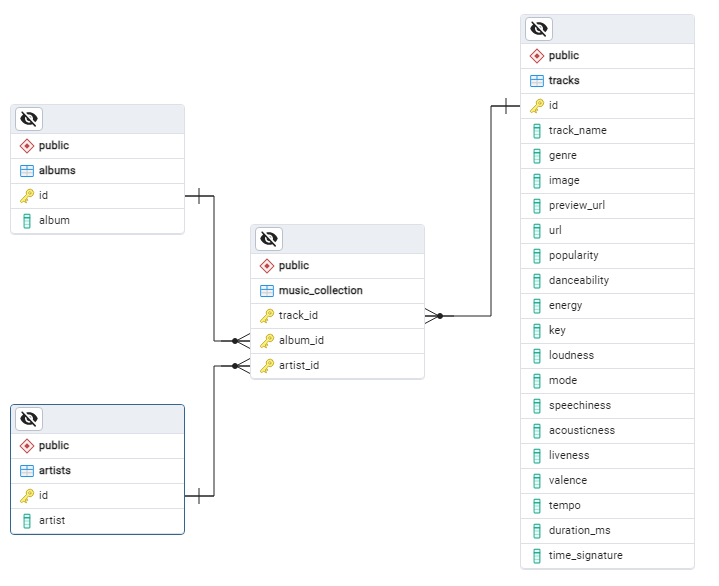